In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
import json
token = {"username":"mandavagnaneshwar","key":"ed4ddd78a3cb2d3664a04368004f2925"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install feature_engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as snb
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from feature_engine.missing_data_imputers import MeanMedianImputer, CategoricalVariableImputer, AddMissingIndicator
from feature_engine.categorical_encoders import OneHotCategoricalEncoder, RareLabelCategoricalEncoder,OrdinalCategoricalEncoder
from feature_engine.outlier_removers import OutlierTrimmer
from feature_engine import variable_transformers
from feature_engine.discretisers import EqualWidthDiscretiser

In [ ]:
train = pd.read_csv('/content/{/content}/competitions/house-prices-advanced-regression-techniques/train.csv')

In [ ]:
test = pd.read_csv('/content/{/content}/competitions/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
#removing ID Column
train = train.drop(columns=["Id"])
test = test.drop(columns=["Id"])


In [ ]:
# Function for plot and check Data Distribution

def diagnostic_plots(df, variable):
    for i in variable: 
        plt.figure(figsize=(16, 4))

        # histogram
        plt.subplot(1, 3, 1)
    
        snb.distplot(df[i], bins=30)
        plt.title('Histogram')

        # Q-Q plot
        plt.subplot(1, 3, 2)
        stats.probplot(df[i], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')

        # boxplot
        plt.subplot(1, 3, 3)
        snb.boxplot(y=df[i])
        plt.title('Boxplot')
        
        print("\n***********{}**********\n".format(i))
        print("**Skewness: ",df[i].skew())
        plt.show()


In [ ]:
# Function to plot relationship between Categorical Variable and Target
#~ Function to plot relationship between Categorical Variable and Target

def explore_relation_catTotar(dataX,y,col_category):
    temp = dataX.copy()
    temp["target"]=y
    for i in col_category:
        fig = plt.figure()
        fig = temp.groupby([i])["target"].mean().plot()
        fig.set_title('Relationship between {} and Item_Outlet_Sales'.format(i))
        fig.set_ylabel('Mean Item_Outlet_Sales')
        plt.show()

In [ ]:
# Basic Functions for Outlier Detection - Skewed Distribution & Gaussian Distribution

#Skewed Distribution

def skewed_outlier(df, variable):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 3)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 3)

    return upper_boundary, lower_boundary

def calculating_outlier_skewed(df,variables):
    dic = {}
    for i in variables:
        ub, lb = skewed_outlier(df,i)
        ub_len = len(df[df[i]>ub])
        lb_len = len(df[df[i]<lb])
        per_total = ((ub_len + lb_len)/len(df))*100
        if per_total != 0:
            dic[i]=per_total
    return dic


# Gaussian Distribution

def gaussian_outlier(df,variable):
    
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary


def calculating_outlier_gaussian(df,variables):
    dic = {}
    for i in variables:
        ub, lb = gaussian_outlier(df,i)
        ub_len = len(df[df[i]>ub])
        lb_len = len(df[df[i]<lb])
        per_total = ((ub_len + lb_len)/len(df))*100
        if per_total != 0:
            dic[i]=per_total
    return dic

In [ ]:
#calculating number of years after house is sold
train['SoldAfterYears'] = train['YrSold'] - train['YearBuilt']
test['SoldAfterYears'] = test['YrSold'] - test['YearBuilt']

#Calculating Number of Months after house was sold
train['SoldAfterMonths'] = ((train['YrSold'] - train['YearBuilt'])*12)  + train['MoSold']
test['SoldAfterMonths'] = ((test['YrSold'] - test['YearBuilt'])*12)  + test['MoSold']


#calculating Renovation after years and difference in the renovations year and build year
train['RenovationCalculation']=train['SoldAfterYears'] - (train['YearRemodAdd'] - train['YearBuilt'])
test['RenovationCalculation']=test['SoldAfterYears'] - (test['YearRemodAdd'] - test['YearBuilt'])



#Adding New Renovation Column
# 0 - No renovation
# 1 - Renovation done
renovation_train = list(map(lambda x, y : 0 if x-y==0 else 1,train['YearRemodAdd'],train['YearBuilt']))
renovation_test = list(map(lambda x, y : 0 if x-y==0 else 1,test['YearRemodAdd'],test['YearBuilt']))
train['Renovation_Done'] = renovation_train
test['Renovation_Done'] = renovation_test


#updating garage status as per the Garage_built_year
train["Garage_status"] = train["GarageYrBlt"] - train['YearBuilt']
train['Garage_status'] = train.Garage_status.fillna(-1)
train['Garage_status'] = train['Garage_status'].replace([i for i in range(-20,0)],'No_Garag')
train['Garage_status'] = train['Garage_status'].replace(0,'Built-in')
train['Garage_status'] = train['Garage_status'].replace([i for i in range (1,210)],'Built-Later')

test["Garage_status"] = test["GarageYrBlt"] - test['YearBuilt']
test['Garage_status'] = test.Garage_status.fillna(-1)
test['Garage_status'] = test['Garage_status'].replace([i for i in range(-20,0)],'No_Garag')
test['Garage_status'] = test['Garage_status'].replace(0,'Built-in')
test['Garage_status'] = test['Garage_status'].replace([i for i in range (1,210)],'Built-Later')


In [ ]:
#due to wrong values some of the output getting in -ve. replacing these with 0
train['RenovationCalculation'] = train['RenovationCalculation'].replace([-1],0)
test['RenovationCalculation'] = test['RenovationCalculation'].replace([-1,-2],0)


In [ ]:
#Dropping the columns which are related to Date/Years after extracting the usefull informations
train = train.drop(columns=['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt','SoldAfterMonths'],axis=1)
test = test.drop(columns=['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt','SoldAfterMonths'],axis=1)



In [ ]:
#Separating Numerical and Categorical Columns
col_number = [i for i in train.columns if train[i].dtype!='O']
col_category =[ i for i in train.columns if train[i].dtype=='O']

In [ ]:
#checking the Numerical columns which has less than 20 unique values
# let's visualise the values of the discrete variables
discrete = []

for var in col_number:
    if len(train[var].unique()) < 20:
        print(var, ' values: ', train[var].unique())
        discrete.append(var)
print('\nThere are {} discrete variables'.format(len(discrete)))



MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
Renovation_Done  values:  [0 1]

There are 15 discrete variables


In [ ]:


cols_to_remove = ['OverallQual','FullBath','TotRmsAbvGrd','GarageCars']
for i in cols_to_remove:
    discrete.remove(i)



In [ ]:


#Convert rest of discrete variables into Categorical.
train[discrete] = train[discrete].astype(str)
test[discrete] = test[discrete].astype(str)



In [ ]:
train = train.drop(columns=['1stFlrSF','BsmtFinSF2','LowQualFinSF','3SsnPorch','MiscVal','EnclosedPorch','ScreenPorch'],axis=1)
test = test.drop(columns=['1stFlrSF','BsmtFinSF2','LowQualFinSF','3SsnPorch','MiscVal','EnclosedPorch','ScreenPorch'],axis=1)

In [ ]:


#Separating Numerical and Categorical Columns
col_number = [i for i in train.columns if train[i].dtype!='O']
col_category =[ i for i in train.columns if train[i].dtype=='O']



In [ ]:
discrete1 = []

for var in col_number:
    if len(train[var].unique()) < 20:
        print(var, ' values: ', train[var].unique())
        discrete1.append(var)
print()
print('There are {} discrete variables'.format(len(discrete1)))

OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
FullBath  values:  [2 1 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
GarageCars  values:  [2 3 1 0 4]

There are 4 discrete variables


In [ ]:
#removing them from separated col_number list

for i in discrete1:
    col_number.remove(i)


In [ ]:
#As per the skewness, seperating the "Skewed Features" & "Gaussian Features"
skewnewss = dict(train[col_number].skew())
gaussian_features =[]
skewed_features =[]
for i,j in skewnewss.items():
    if (skewnewss[i]<0.75) and (skewnewss[i]> -0.75):
        gaussian_features.append(i)
    else:
        skewed_features.append(i)

In [ ]:
#calculating the outlier present in each column in (%) ~ functions are defined above
gaussian_outlier_percentage = calculating_outlier_gaussian(train,gaussian_features)
skewed_outlier_percentage = calculating_outlier_skewed(train,skewed_features)


In [ ]:
#getting all those column names in the list
skewed_outlier_cols_list = list(skewed_outlier_percentage.keys())
gaussian_outlier_cols_list = list(gaussian_outlier_percentage.keys())


In [ ]:
for i in ['LotFrontage','MasVnrArea']:
    skewed_outlier_cols_list.remove(i)

In [ ]:
#Creating Pipeline to remove the outliers

outlier_trimmer_pipe = Pipeline(steps=[
    ('Gaussian_Outliers',OutlierTrimmer(distribution='gaussian',tail='both',
                                       fold=3, variables=gaussian_outlier_cols_list)),
    ("Skewed_Outlier",OutlierTrimmer(distribution='skewed',tail='both',
                                    fold=3, variables=skewed_outlier_cols_list))
])

outlier_trimmer_pipe.fit(train)
train = outlier_trimmer_pipe.transform(train)

In [ ]:
train.shape

(1386, 73)

In [ ]:
use_cols=list(train.columns)
use_cols.remove("SalePrice")

X_train, X_test, y_train, y_test = train_test_split(train[use_cols],train["SalePrice"],
                                                    test_size=0.25,random_state=2)

X_train.shape, X_test.shape


((1039, 72), (347, 72))

In [ ]:
missing_data_var_Xtrain = [c for c in X_train.columns if X_train[c].isnull().mean() != 0]


In [ ]:
#Variable "GarageCars" from test set is not matching X_train
test['GarageCars'] = test['GarageCars'].replace(['nan'],'0')
test['GarageCars'] = test['GarageCars'].replace(['5.0'],'4')
test['GarageCars'] = test['GarageCars'].replace(['0.0'],'0')
test['GarageCars'] = test['GarageCars'].replace(['1.0'],'1')
test['GarageCars'] = test['GarageCars'].replace(['2.0'],'2')
test['GarageCars'] = test['GarageCars'].replace(['3.0'],'3')
test['GarageCars'] = test['GarageCars'].replace(['4.0'],'4')

In [ ]:
#Separating Numerical and Categorical Columns from X_train missing_values columns
missing_number = [i for i in missing_data_var_Xtrain if X_train[i].dtype!='O']
missing_category =[ i for i in missing_data_var_Xtrain if X_train[i].dtype=='O']


In [ ]:
missing_number

['LotFrontage', 'MasVnrArea']

In [ ]:
num_impute_pipeline = Pipeline(steps=[
    ("Missing Indicator",AddMissingIndicator(variables=["LotFrontage"])), #Addming missing indicator
    ("Median_imputation",MeanMedianImputer(imputation_method="median",variables=['LotFrontage',"MasVnrArea"]))
])

num_impute_pipeline.fit(X_train)
X_train = num_impute_pipeline.transform(X_train)
X_test = num_impute_pipeline.transform(X_test)
test = num_impute_pipeline.transform(test)


In [ ]:
cat_missing_data = ['MasVnrType','Electrical']
cat_missing_labels = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                  'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC',
                  'Fence', 'MiscFeature']



In [ ]:
#creating a Pipeline to impute the missing_values in categorical variables
category_missing_pipe = Pipeline(steps=[
    ('Frequent_category',CategoricalVariableImputer(imputation_method='frequent',
                                                   variables=cat_missing_data)),
    ('Missing_Labels',CategoricalVariableImputer(imputation_method='missing',
                                                variables=cat_missing_labels))
])


#imputing the missing value
category_missing_pipe.fit(X_train)
X_train = category_missing_pipe.transform(X_train)
X_test = category_missing_pipe.transform(X_test)
test = category_missing_pipe.transform(test)


In [ ]:
#Checking if there are any missing date in Test Set now
missing_data_var_test = [c for c in test.columns if test[c].isnull().mean() != 0]
test[missing_data_var_test].isnull().mean()*100


MSZoning       0.27416
Utilities      0.13708
Exterior1st    0.06854
Exterior2nd    0.06854
BsmtFinSF1     0.06854
BsmtUnfSF      0.06854
TotalBsmtSF    0.06854
KitchenQual    0.06854
Functional     0.13708
GarageCars     0.06854
GarageArea     0.06854
SaleType       0.06854
dtype: float64

In [ ]:
#Separating Numerical and Categorical Columns from test missing_values columns
test_missing_number = [i for i in missing_data_var_test if test[i].dtype!='O']
test_missing_category =[ i for i in missing_data_var_test if test[i].dtype=='O']


In [ ]:
test[test_missing_number].isnull().mean()

BsmtFinSF1     0.000685
BsmtUnfSF      0.000685
TotalBsmtSF    0.000685
GarageCars     0.000685
GarageArea     0.000685
dtype: float64

In [ ]:
test_imputer_remaining = MeanMedianImputer(imputation_method="median",
                                          variables=test_missing_number)

test_imputer_remaining.fit(X_train)
test = test_imputer_remaining.transform(test)


In [ ]:
test[test_missing_category].isnull().mean()

MSZoning       0.002742
Utilities      0.001371
Exterior1st    0.000685
Exterior2nd    0.000685
KitchenQual    0.000685
Functional     0.001371
SaleType       0.000685
dtype: float64

In [ ]:
test_imputer_cat = CategoricalVariableImputer(imputation_method='frequent',
                                             variables=test_missing_category)

test_imputer_cat.fit(X_train)
test = test_imputer_cat.transform(test)



In [ ]:
#Separating Numerical and Categorical Columns
col_number = [i for i in X_train.columns if X_train[i].dtype!='O']
col_category =[ i for i in X_train.columns if X_train[i].dtype=='O']

In [ ]:
X_train[col_number].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
LotFrontage,1039.0,68.239654,19.583656,21.0,60.0,68.0,78.0,182.0
LotArea,1039.0,9390.133782,3540.052417,1300.0,7369.0,9337.0,11276.0,23257.0
OverallQual,1039.0,6.020212,1.341704,1.0,5.0,6.0,7.0,10.0
MasVnrArea,1039.0,94.637151,164.609423,0.0,0.0,0.0,149.5,1600.0
BsmtFinSF1,1039.0,425.698749,418.389290,0.0,0.0,375.0,700.0,1696.0
BsmtUnfSF,1039.0,552.358037,438.177849,0.0,216.5,458.0,788.5,2336.0
TotalBsmtSF,1039.0,1027.197305,392.190480,0.0,788.0,975.0,1264.0,2392.0
2ndFlrSF,1039.0,330.197305,419.649839,0.0,0.0,0.0,709.0,1611.0
GrLivArea,1039.0,1473.998075,466.224519,438.0,1120.5,1436.0,1734.0,3447.0
FullBath,1039.0,1.545717,0.540800,0.0,1.0,2.0,2.0,3.0


In [ ]:
log_transform = ['LotFrontage','LotArea','GrLivArea'] #does not have 0
box_cox_transform = ['MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF',
                     '2ndFlrSF','GarageArea','WoodDeckSF','OpenPorchSF']
avoid = ['OverallQual','FullBath','TotRmsAbvGrd','GarageCars','LotFrontage_na']
scalar_PCA = []

for i in col_number:
    if i not in avoid:
        scalar_PCA.append(i)

In [ ]:
X_train[['PoolArea','MSSubClass']]=X_train[['PoolArea','MSSubClass']].astype(int)
X_test[['PoolArea','MSSubClass']]=X_test[['PoolArea','MSSubClass']].astype(int)
test[['PoolArea','MSSubClass']]=test[['PoolArea','MSSubClass']].astype(int)


In [ ]:
disc_pipe = Pipeline(steps=[
    ('PoolArea_disc',EqualWidthDiscretiser(bins = 2, variables=['PoolArea'])),
    ('MSSubClass_disc',EqualWidthDiscretiser(bins=8,variables=['MSSubClass'])),   
])

disc_pipe.fit(X_train)
X_train = disc_pipe.transform(X_train)
X_test = disc_pipe.transform(X_test)
test = disc_pipe.transform(test)

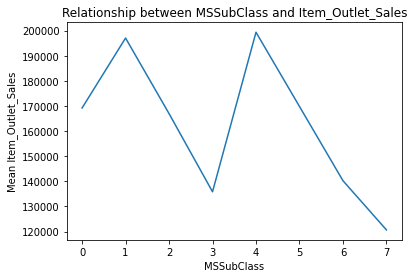

In [ ]:
explore_relation_catTotar(X_train,y_train,['MSSubClass'])

In [ ]:
X_train[['MSSubClass']]=X_train[['MSSubClass']].astype(str)
X_test[['MSSubClass']]=X_test[['MSSubClass']].astype(str)
test[['MSSubClass']]=test[['MSSubClass']].astype(str)



In [ ]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
test1 = test.copy()

In [ ]:


#Separating Numerical and Categorical Columns
col_number = [i for i in X_train1.columns if X_train1[i].dtype!='O']
col_category =[ i for i in X_train1.columns if X_train1[i].dtype=='O']



In [ ]:
rare_encoder = RareLabelCategoricalEncoder(tol=0.05,
                                                   n_categories=1,
                                                    variables=col_category)

rare_encoder.fit(X_train1)
X_train1 = rare_encoder.transform(X_train1)
X_test1 = rare_encoder.transform(X_test1)
test1 = rare_encoder.transform(test1)

In [ ]:
ordered =[]
one_hot=[]
for i in col_category:
    if len(X_train1[i].unique())>=5:
        ordered.append(i)
    else:
        one_hot.append(i)

In [ ]:
target_encoding = OrdinalCategoricalEncoder(encoding_method="ordered",
                                           variables=ordered)

target_encoding.fit(X_train1,y_train)



OrdinalCategoricalEncoder(encoding_method='ordered',
                          variables=['MSSubClass', 'Neighborhood',
                                     'OverallCond', 'Exterior1st',
                                     'Exterior2nd', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageType', 'MoSold'])

In [ ]:
X_train1 = target_encoding.transform(X_train1)
X_test1 = target_encoding.transform(X_test1)
test1 = target_encoding.transform(test1)


In [ ]:
one_hot = OneHotCategoricalEncoder(top_categories=None,
                                  variables=one_hot,
                                  drop_last=True)

one_hot.fit(X_train1)

OneHotCategoricalEncoder(drop_last=True, top_categories=None,
                         variables=['MSZoning', 'Street', 'Alley', 'LotShape',
                                    'LandContour', 'Utilities', 'LotConfig',
                                    'LandSlope', 'Condition1', 'Condition2',
                                    'BldgType', 'HouseStyle', 'RoofStyle',
                                    'RoofMatl', 'MasVnrType', 'ExterQual',
                                    'ExterCond', 'Foundation', 'BsmtQual',
                                    'BsmtCond', 'BsmtFinType2', 'Heating',
                                    'HeatingQC', 'CentralAir', 'Electrical',
                                    'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
                                    'BedroomAbvGr', 'KitchenAbvGr', ...])

In [ ]:
X_train1 = one_hot.transform(X_train1)
X_test1 = one_hot.transform(X_test1)
test1 = one_hot.transform(test1)


In [ ]:
X_train1.shape, X_test1.shape,test1.shape

((1039, 114), (347, 114), (1459, 114))

In [ ]:
X_train2 = X_train1.copy()
X_test2 = X_test1.copy()
test2 = test1.copy()


In [ ]:
X_train2_scalar_pca = X_train2[scalar_PCA].copy()
X_test2_scalar_pca = X_test1[scalar_PCA].copy()
test2_scalar_pca = test2[scalar_PCA].copy()


X_train2 = X_train2.drop(columns=scalar_PCA,axis=1)
X_test2 = X_test2.drop(columns=scalar_PCA,axis=1)
test2 = test2.drop(columns=scalar_PCA,axis=1)


In [ ]:
scalar = StandardScaler()

scalar.fit(X_train2_scalar_pca)
X_train2_scalar_pca = scalar.transform(X_train2_scalar_pca)
X_test2_scalar_pca = scalar.transform(X_test2_scalar_pca)
test2_scalar_pca = scalar.transform(test2_scalar_pca)

In [ ]:

X_train2_scalar_pca.shape
pca = PCA(n_components=11)
pca.fit(X_train2_scalar_pca)



PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train2_scalar_pca = pca.transform(X_train2_scalar_pca)
X_test2_scalar_pca = pca.transform(X_test2_scalar_pca)
test2_scalar_pca = pca.transform(test2_scalar_pca)



In [ ]:


np.cumsum(pca.explained_variance_ratio_)



array([0.28666501, 0.41956514, 0.53617646, 0.64929987, 0.72047433,
       0.78889315, 0.8436009 , 0.89143847, 0.93024198, 0.96189917,
       0.98821561])

In [ ]:
pca.explained_variance_ratio_

array([0.28666501, 0.13290013, 0.11661132, 0.1131234 , 0.07117446,
       0.06841882, 0.05470775, 0.04783757, 0.03880351, 0.03165719,
       0.02631644])

In [ ]:
cols = []
for i in range (0,len(pca.explained_variance_ratio_)):
    var = 'col'+ str(i)
    cols.append(var)

X_train_pca=pd.DataFrame(data=X_train2_scalar_pca,columns=cols)
X_test_pca = pd.DataFrame(data=X_test2_scalar_pca,columns=cols)
test_pca = pd.DataFrame(data=test2_scalar_pca,columns=cols)

In [ ]:
X_train_pca.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,-0.524377,1.685432,-2.656581,-0.399734,0.239513,0.718788,-0.724460,0.550488,0.294221,0.196958,-0.415419
1,-0.443229,2.300637,0.354810,-0.655470,1.513176,-1.691463,0.724844,1.290569,-0.066116,-0.287054,0.846751
2,-1.489609,-1.758238,0.285579,-0.495708,0.707252,0.710842,0.450121,-0.067975,-0.538528,0.110332,-0.398906
3,-1.970225,-1.795317,-0.621187,-0.876948,0.528733,0.954520,0.318964,0.241166,-1.879471,-1.113337,-0.850867
4,0.160287,1.332296,0.522649,-0.771833,0.245838,1.571044,0.773827,-0.683443,0.048057,0.115297,-0.348011


In [ ]:
X_train2 = X_train2.reset_index(drop=True)
X_train2.head()


,MSSubClass,Neighborhood,OverallQual,OverallCond,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,FullBath,TotRmsAbvGrd,GarageType,GarageCars,PoolArea,MoSold,LotFrontage_na,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Missing,LotShape_Reg,LotShape_IR1,LandContour_Lvl,Utilities_AllPub,LotConfig_Inside,LotConfig_CulDSac,LotConfig_Corner,LandSlope_Gtl,Condition1_Norm,Condition1_Feedr,Condition2_Norm,BldgType_Rare,BldgType_1Fam,HouseStyle_2Story,HouseStyle_1.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Rare,RoofMatl_CompShg,MasVnrType_Stone,MasVnrType_None,...,BsmtFullBath_1,BsmtHalfBath_0,BsmtHalfBath_Rare,HalfBath_1,HalfBath_0,BedroomAbvGr_2,BedroomAbvGr_4,BedroomAbvGr_3,KitchenAbvGr_1,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Rare,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,FireplaceQu_Missing,FireplaceQu_Gd,FireplaceQu_Rare,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Missing,GarageQual_TA,GarageQual_Missing,GarageCond_TA,GarageCond_Missing,PavedDrive_Y,PavedDrive_N,PoolQC_Missing,Fence_Missing,Fence_Rare,MiscFeature_Missing,SaleType_WD,SaleType_Rare,SaleCondition_Normal,SaleCondition_Rare,SaleCondition_Partial,Renovation_Done_0,Garage_status_Built-in,Garage_status_Built-Later
0,0,7,7,4,5,4,1,5,2,6,4,2,0,2,0,1,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,1,0,1,1,0,...,0,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0
1,4,3,6,2,0,4,1,5,2,10,1,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1
2,3,3,4,4,5,5,2,1,1,5,3,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,...,1,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0
3,1,1,6,4,4,2,4,6,2,4,0,0,0,6,0,1,0,1,1,0,1,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,0,1,1,0,0,1,0,1,0,0
4,4,2,6,1,2,3,1,1,1,8,3,2,0,0,0,1,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0


In [ ]:
X_train_model = X_train2.merge(X_train_pca,left_index=True, right_index=True)
X_train_model.head()



,MSSubClass,Neighborhood,OverallQual,OverallCond,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,FullBath,TotRmsAbvGrd,GarageType,GarageCars,PoolArea,MoSold,LotFrontage_na,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Missing,LotShape_Reg,LotShape_IR1,LandContour_Lvl,Utilities_AllPub,LotConfig_Inside,LotConfig_CulDSac,LotConfig_Corner,LandSlope_Gtl,Condition1_Norm,Condition1_Feedr,Condition2_Norm,BldgType_Rare,BldgType_1Fam,HouseStyle_2Story,HouseStyle_1.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Rare,RoofMatl_CompShg,MasVnrType_Stone,MasVnrType_None,...,KitchenQual_Rare,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,FireplaceQu_Missing,FireplaceQu_Gd,FireplaceQu_Rare,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Missing,GarageQual_TA,GarageQual_Missing,GarageCond_TA,GarageCond_Missing,PavedDrive_Y,PavedDrive_N,PoolQC_Missing,Fence_Missing,Fence_Rare,MiscFeature_Missing,SaleType_WD,SaleType_Rare,SaleCondition_Normal,SaleCondition_Rare,SaleCondition_Partial,Renovation_Done_0,Garage_status_Built-in,Garage_status_Built-Later,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,0,7,7,4,5,4,1,5,2,6,4,2,0,2,0,1,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,-0.524377,1.685432,-2.656581,-0.399734,0.239513,0.718788,-0.724460,0.550488,0.294221,0.196958,-0.415419
1,4,3,6,2,0,4,1,5,2,10,1,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1,-0.443229,2.300637,0.354810,-0.655470,1.513176,-1.691463,0.724844,1.290569,-0.066116,-0.287054,0.846751
2,3,3,4,4,5,5,2,1,1,5,3,1,0,1,0,1,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,...,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,-1.489609,-1.758238,0.285579,-0.495708,0.707252,0.710842,0.450121,-0.067975,-0.538528,0.110332,-0.398906
3,1,1,6,4,4,2,4,6,2,4,0,0,0,6,0,1,0,1,1,0,1,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,0,1,1,0,0,1,0,1,0,0,-1.970225,-1.795317,-0.621187,-0.876948,0.528733,0.954520,0.318964,0.241166,-1.879471,-1.113337,-0.850867
4,4,2,6,1,2,3,1,1,1,8,3,2,0,0,0,1,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0.160287,1.332296,0.522649,-0.771833,0.245838,1.571044,0.773827,-0.683443,0.048057,0.115297,-0.348011


In [ ]:
X_test2 = X_test2.reset_index(drop=True)
X_test_model = X_test2.merge(X_test_pca,left_index=True, right_index=True)
X_test_model.head()


,MSSubClass,Neighborhood,OverallQual,OverallCond,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,FullBath,TotRmsAbvGrd,GarageType,GarageCars,PoolArea,MoSold,LotFrontage_na,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Missing,LotShape_Reg,LotShape_IR1,LandContour_Lvl,Utilities_AllPub,LotConfig_Inside,LotConfig_CulDSac,LotConfig_Corner,LandSlope_Gtl,Condition1_Norm,Condition1_Feedr,Condition2_Norm,BldgType_Rare,BldgType_1Fam,HouseStyle_2Story,HouseStyle_1.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Rare,RoofMatl_CompShg,MasVnrType_Stone,MasVnrType_None,...,KitchenQual_Rare,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,FireplaceQu_Missing,FireplaceQu_Gd,FireplaceQu_Rare,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Missing,GarageQual_TA,GarageQual_Missing,GarageCond_TA,GarageCond_Missing,PavedDrive_Y,PavedDrive_N,PoolQC_Missing,Fence_Missing,Fence_Rare,MiscFeature_Missing,SaleType_WD,SaleType_Rare,SaleCondition_Normal,SaleCondition_Rare,SaleCondition_Partial,Renovation_Done_0,Garage_status_Built-in,Garage_status_Built-Later,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,1,2,7,0,4,4,3,4,1,6,3,2,0,4,1,1,0,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,1,0,0.533204,-1.640019,-0.055645,-0.734074,-0.443662,-0.137793,0.088913,-0.984376,-0.228161,-0.939961,1.261740
1,4,0,5,2,4,4,1,3,1,5,1,1,0,1,0,0,1,1,0,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,-2.681567,0.665080,-0.345851,-0.541502,0.105518,0.677879,0.924287,0.358469,0.322675,0.835946,-0.645154
2,3,0,4,1,0,0,1,5,2,5,1,1,0,7,0,1,0,1,0,1,0,1,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,...,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1,-2.113710,0.346240,0.021933,0.896650,-0.361030,-0.432835,-0.858330,0.086406,-1.008071,-1.015077,1.379985
3,4,3,7,2,4,4,1,1,1,6,3,1,0,2,0,1,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,1,0,-0.315205,2.049844,1.526595,-0.243203,-0.020385,-0.149019,-0.560915,1.361223,-1.259873,0.484696,0.109131
4,4,6,7,4,4,4,1,6,2,7,3,2,0,6,0,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,1,0,...,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,0,1,1.163791,-0.286634,-1.272418,-0.864067,-2.121869,0.623077,0.654985,-0.282609,-0.689127,0.120093,-0.240155


In [ ]:
test2 = test2.reset_index(drop=True)
test_model = test2.merge(test_pca,left_index=True, right_index=True)
test_model.head()



,MSSubClass,Neighborhood,OverallQual,OverallCond,Exterior1st,Exterior2nd,BsmtExposure,BsmtFinType1,FullBath,TotRmsAbvGrd,GarageType,GarageCars,PoolArea,MoSold,LotFrontage_na,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Missing,LotShape_Reg,LotShape_IR1,LandContour_Lvl,Utilities_AllPub,LotConfig_Inside,LotConfig_CulDSac,LotConfig_Corner,LandSlope_Gtl,Condition1_Norm,Condition1_Feedr,Condition2_Norm,BldgType_Rare,BldgType_1Fam,HouseStyle_2Story,HouseStyle_1.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Rare,RoofMatl_CompShg,MasVnrType_Stone,MasVnrType_None,...,KitchenQual_Rare,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,FireplaceQu_Missing,FireplaceQu_Gd,FireplaceQu_Rare,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Missing,GarageQual_TA,GarageQual_Missing,GarageCond_TA,GarageCond_Missing,PavedDrive_Y,PavedDrive_N,PoolQC_Missing,Fence_Missing,Fence_Rare,MiscFeature_Missing,SaleType_WD,SaleType_Rare,SaleCondition_Normal,SaleCondition_Rare,SaleCondition_Partial,Renovation_Done_0,Garage_status_Built-in,Garage_status_Built-Later,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
0,3,2,5,1,5,5,1,1,1,5,3,1.0,0,2,0,0,0,1,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,...,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,-0.746000,-1.264682,1.311292,0.173911,0.220462,-0.408492,-0.379476,-0.810439,1.719756,-0.167071,0.093527
1,3,2,6,1,0,0,1,4,1,6,3,1.0,0,2,0,1,0,1,1,0,1,1,1,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1,0,0,...,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,1,1,0,0.358289,-1.730777,1.820464,-0.088984,1.231112,-1.885399,1.554704,-0.526092,-0.397196,-0.052513,-0.535879
2,4,4,5,4,5,5,1,6,2,6,3,2.0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1.032051,-0.366071,0.535965,-1.519076,-0.266660,-1.343636,-0.628298,0.032034,-0.154883,-0.440339,-0.545334
3,4,4,6,1,5,5,1,6,2,7,3,2.0,0,2,0,1,0,1,1,0,1,1,1,1,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,1.059730,-0.144150,-0.185278,-1.204446,0.517229,-2.128544,-0.255511,-0.440482,-0.023598,0.523750,-0.368026
4,5,3,8,4,2,3,1,4,2,5,3,2.0,0,5,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,...,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,0,-0.281725,-0.056561,-1.939731,1.422168,-0.732371,0.489038,0.540460,0.602627,0.513099,-0.035366,-0.245156


In [ ]:
X_train_model.shape, X_test_model.shape,test_model.shape


((1039, 112), (347, 112), (1459, 112))

In [ ]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)


In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
param = {'objective':['reg:squarederror'],
         'learning_rate': [0.1,0.11,0.12,0.13,0.15,0.2],
        'max_depth': [1,2,3,4,5]}

xgb1 = XGBRegressor()

xgb_grid = GridSearchCV(xgb1, param, cv = 3)

xgb_grid.fit(X_train_model, y_train_log)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.11, 0.12, 0.13, 0.15, 0.2],
                         'max_depth': [1, 2, 3, 4, 5],

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8806668517881224
{'learning_rate': 0.11, 'max_depth': 3, 'objective': 'reg:squarederror'}


In [ ]:
y_predict_train = xgb_grid.predict(X_train_model)
y_predict_test =  xgb_grid.predict(X_test_model)


In [ ]:
print("\nTraining RMSE and R-Square: ")
print("Root Mean Square Error :",mean_squared_error(y_train_log,y_predict_train)**0.5)


print("\nTesting RMSE and R-Square: ")
print("Root Mean Square Error :",mean_squared_error(y_test_log,y_predict_test)**0.5)



Training RMSE and R-Square: 
Root Mean Square Error : 0.08497107479223645

Testing RMSE and R-Square: 
Root Mean Square Error : 0.11813862911064993


In [ ]:
#Accuracy of Model

print('**Interpretation**')
print('Train Accuracy',xgb_grid.score(X_train_model, y_train_log))
print('Test Accuracy',xgb_grid.score(X_test_model, y_test_log))

**Interpretation**
Train Accuracy 0.9509222333135742
Test Accuracy 0.8918589304964242


In [ ]:
# Import stats model
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
print('Adjusted R Squared: ', model.rsquared_adj)


Adjusted R Squared:  0.9050567494138373


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor


In [ ]:
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
ada_clf_rand = AdaBoostRegressor(RandomForestRegressor())

ada_clf_rand.fit(X_train_model, y_train_log)
y_pred = ada_clf_rand.predict(X_test_model)
# Print the score of the fitted model
print('**Interpretation**')
print('r2_score: ',r2_score(y_test_log, y_pred))

#RMSE Value
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
print('RMSE: ', rmse)



print('**Interpretation**')
print('Train Accuracy: ', ada_clf_rand.score(X_train_model, y_train_log))
print('Test Accuracy: ', ada_clf_rand.score(X_test_model, y_test_log))

#Adjusted R Squared
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
#print(model.params)
print('Adjusted R Squared ', model.rsquared_adj)


**Interpretation**
r2_score:  0.895250071605637
RMSE:  0.11627155056991204
**Interpretation**
Train Accuracy:  0.9935976083138194
Test Accuracy:  0.8952500716056369
Adjusted R Squared  0.9050567494138373


In [ ]:

ada_clf = AdaBoostRegressor()


In [ ]:
ada_clf.fit(X_train_model, y_train_log)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)

In [ ]:
y_pred = ada_clf.predict(X_test_model)


In [ ]:
print("\nTesting RMSE and R-Square: ")
print("Root Mean Square Error :",mean_squared_error(y_test_log,y_pred)**0.5)


Testing RMSE and R-Square: 
Root Mean Square Error : 0.1431170428659134


In [ ]:
print('Train Accuracy: ', ada_clf.score(X_train_model, y_train_log))
print('Test Accuracy: ', ada_clf.score(X_test_model, y_test_log))

Train Accuracy:  0.8766675154583374
Test Accuracy:  0.8412954000534799


In [ ]:
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
print('Adjusted R Squared: ', model.rsquared_adj)

Adjusted R Squared:  0.9050567494138373


In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor


In [ ]:
params = {"max_depth": np.arange(3,10), "min_samples_split": np.arange(5,15)}
model = tree.DecisionTreeRegressor()
grid = GridSearchCV(estimator = model,  param_grid = params, cv  =  10)
grid_model = grid.fit(X_train_model, y_train_log)
grid_model.best_params_

{'max_depth': 5, 'min_samples_split': 13}

In [ ]:
#Building the decision tree
model = tree.DecisionTreeRegressor(max_depth = 5, min_samples_split = 13, random_state = 123)
model = model.fit(X_train_model, y_train_log)
#Predicting the value
y_pred = model.predict(X_test_model)

#Accuracy of Model

print('**Interpretation**')
print('Train Accuracy',model.score(X_train_model, y_train_log))
print('Test Accuracy',model.score(X_test_model, y_test_log))

**Interpretation**
Train Accuracy 0.8764286585812615
Test Accuracy 0.8271558084486785


In [ ]:
print("\nTesting RMSE and R-Square: ")
print("Root Mean Square Error :",mean_squared_error(y_test_log,y_pred)**0.5)


Testing RMSE and R-Square: 
Root Mean Square Error : 0.14935645313059398


In [ ]:
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
print('Adjusted R Squared: ', model.rsquared_adj)

Adjusted R Squared:  0.9050567494138373


In [ ]:
params = {"max_depth": np.arange(3,10), "min_samples_split": np.arange(5,15)}
model = tree.DecisionTreeRegressor()
grid = GridSearchCV(estimator = model,  param_grid = params, cv  =  10)
grid_model = grid.fit(X_train_model, y_train_log)
grid_model.best_params_
#Building the decision tree
model = tree.DecisionTreeRegressor(max_depth = 5, min_samples_split = 13, random_state = 123)
model = model.fit(X_train_model, y_train_log)
#Predicting the value
y_pred = model.predict(X_test_model)

#Accuracy of Model

print('**Interpretation**')
print('Train Accuracy',model.score(X_train_model, y_train_log))
print('Test Accuracy',model.score(X_test_model, y_test_log))
print("\nTesting RMSE and R-Square: ")
print("Root Mean Square Error :",mean_squared_error(y_test_log,y_pred)**0.5)

import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
print('Adjusted R Squared: ', model.rsquared_adj)

**Interpretation**
Train Accuracy 0.8764286585812615
Test Accuracy 0.8271558084486785

Testing RMSE and R-Square: 
Root Mean Square Error : 0.14935645313059398
Adjusted R Squared:  0.9050567494138373


In [ ]:
### random forest

In [ ]:
import math
forest = RandomForestRegressor(n_estimators = 100, random_state = 100, max_depth = 9, min_samples_split=7, verbose=1)
model = forest.fit(X_train_model, y_train_log)
y_pred =  model.predict(X_test_model)

# Print the score of the fitted random forest
print('**Interpretation**')
print('Train Accuracy: ', model.score(X_train_model, y_train_log))
print('Test Accuracy: ', model.score(X_test_model, y_test_log))
rmse = math.sqrt(mean_squared_error(y_test_log, y_pred))
print('RMSE: ' , rmse)

# Import stats model
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
print('Adjusted R Squared: ', model.rsquared_adj)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


**Interpretation**
Train Accuracy:  0.9609168482648942
Test Accuracy:  0.8801318642833937
RMSE:  0.12437940422453198
Adjusted R Squared:  0.9050567494138373


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

params = {"kernel": ('linear', 'rbf'), "gamma": [0.03,1,10], }
model = svm.SVR()
grid = GridSearchCV(model,params)
grid_model = grid.fit(X_train_model,y_train_log)
grid_model.best_params_

{'gamma': 0.03, 'kernel': 'linear'}

In [ ]:
#Build the model
svm_model = svm.SVR(kernel='linear', gamma=0.03)
svm_model.fit(X_train_model, y_train_log)
y_pred = svm_model.predict(X_test_model)
# Print the score of the fitted model
print('**Interpretation**')
print('r2_score: ',r2_score(y_test_log, y_pred))

#RMSE Value
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
print('RMSE: ', rmse)



print('**Interpretation**')
print('Train Accuracy: ', svm_model.score(X_train_model, y_train_log))
print('Test Accuracy: ', svm_model.score(X_test_model, y_test_log))

#Adjusted R Squared
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
#print(model.params)
print('Adjusted R Squared ', model.rsquared_adj)




**Interpretation**
r2_score:  0.890796156121282
RMSE:  0.11871772333182136
**Interpretation**
Train Accuracy:  0.9097690584377458
Test Accuracy:  0.890796156121282
Adjusted R Squared  0.9050567494138373


In [ ]:

#print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train_model, y_train_log)
y_pred = model.predict(X_test_model)
# Print the score of the fitted model
print('**Interpretation**')
print('r2_score: ',r2_score(y_test_log, y_pred))

#RMSE Value
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
print('RMSE: ', rmse)



print('**Interpretation**')
print('Train Accuracy: ', model.score(X_train_model, y_train_log))
print('Test Accuracy: ', model.score(X_test_model, y_test_log))

#Adjusted R Squared
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
#print(model.params)
print('Adjusted R Squared ', model.rsquared_adj)


**Interpretation**
r2_score:  0.8987528873995834
RMSE:  0.11431097265809718
**Interpretation**
Train Accuracy:  0.9559629539194425
Test Accuracy:  0.8987528873995833
Adjusted R Squared  0.9050567494138373


In [ ]:
ada_rand_clf = AdaBoostRegressor(RandomForestRegressor())

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
extra_model=model.fit(X_train_model, y_train_log)
y_pred = extra_model.predict(X_test_model)
# Print the score of the fitted model
print('**Interpretation**')
print('r2_score: ',r2_score(y_test_log, y_pred))

#RMSE Value
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
print('RMSE: ', rmse)



print('**Interpretation**')
print('Train Accuracy: ', extra_model.score(X_train_model, y_train_log))
print('Test Accuracy: ', extra_model.score(X_test_model, y_test_log))

#Adjusted R Squared
import statsmodels.api as sm
X_train1 = sm.add_constant(X_train_model).values
model =sm.OLS(y_train_log,X_train1).fit()
#print(model.params)
print('Adjusted R Squared ', model.rsquared_adj)


**Interpretation**
r2_score:  0.885203437913381
RMSE:  0.1217197461074951
**Interpretation**
Train Accuracy:  0.9999999996842384
Test Accuracy:  0.885203437913381
Adjusted R Squared  0.9050567494138373


In [ ]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred)#, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc[1,1]
    TN = confusion.loc[0,0]
    FP = confusion.loc[0,1]
    FN = confusion.loc[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

In [ ]:
y_pred = svm_model.predict(X_test_model)

SVM_rbf = model_eval(y_test_log, y_pred)
#print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))


KeyError: ignored

In [ ]:
|